Running PCA...
PCA completed in 2.48 seconds


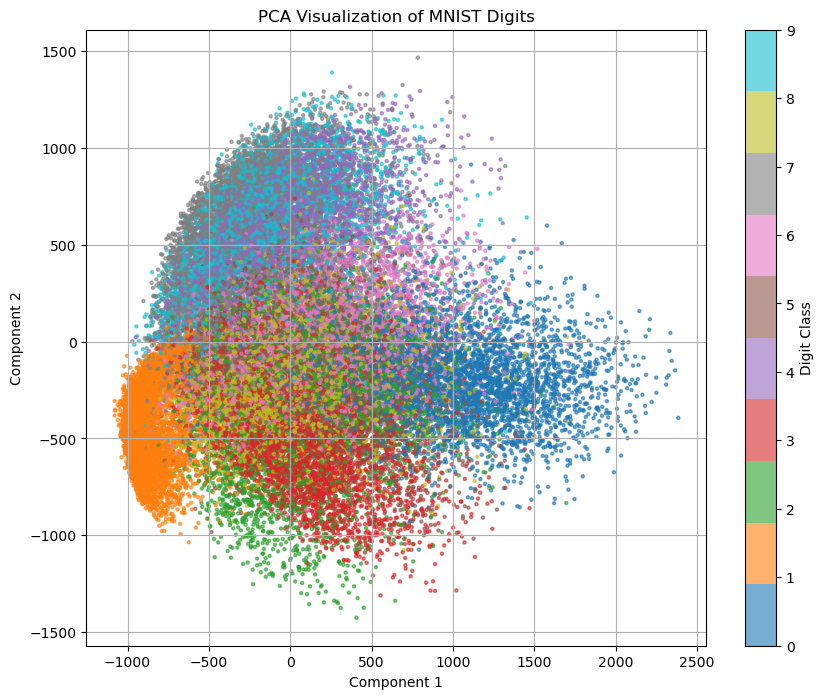

Running t-SNE...
t-SNE completed in 381.28 seconds


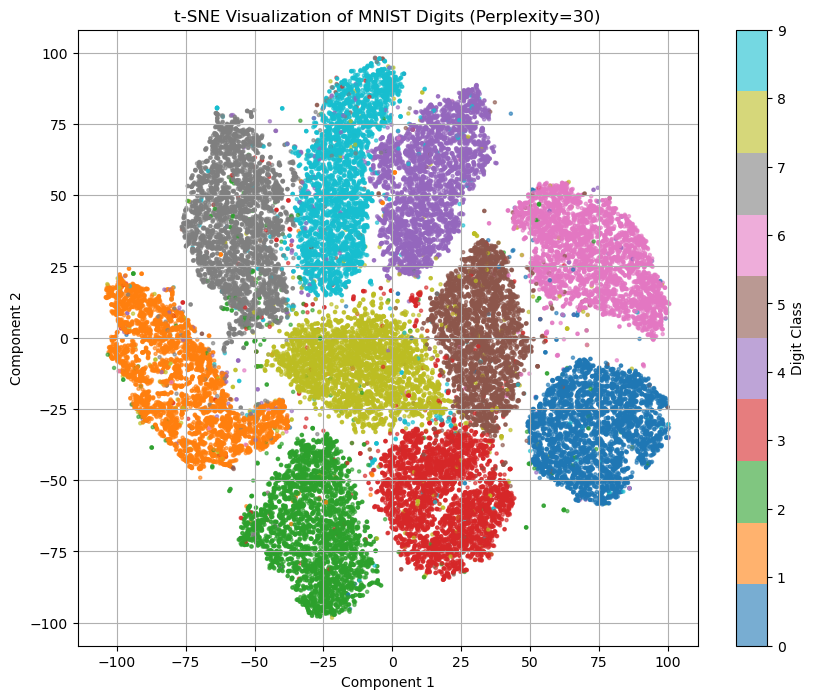

Trustworthiness (PCA, sklearn): 0.9583
Trustworthiness (t-SNE, sklearn): 0.9911

Running t-SNE with perplexity=5...
Completed in 1004.58 seconds
KL divergence: 2.8769
Trustworthiness: 0.9900


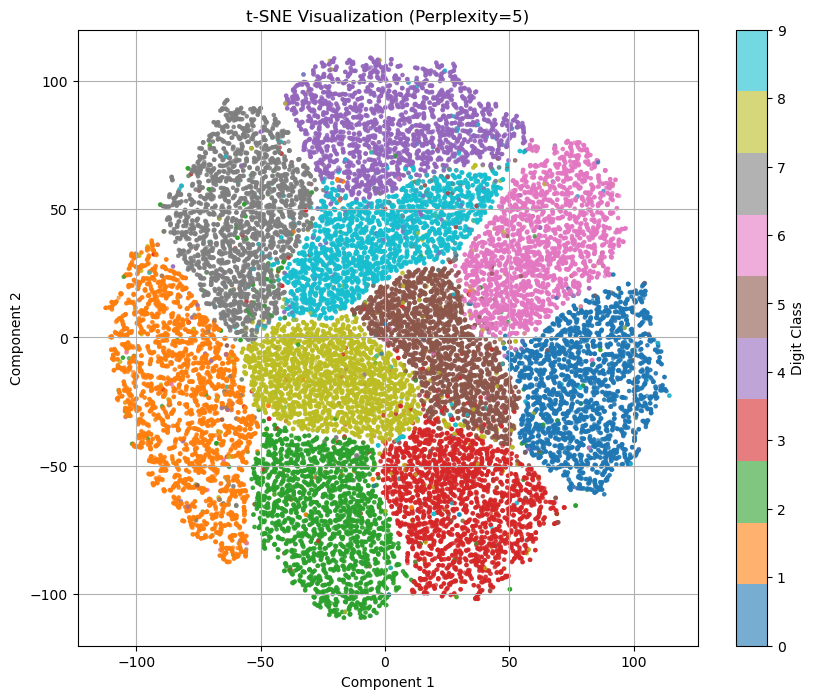


Running t-SNE with perplexity=10...
Completed in 981.12 seconds
KL divergence: 2.7605
Trustworthiness: 0.9918


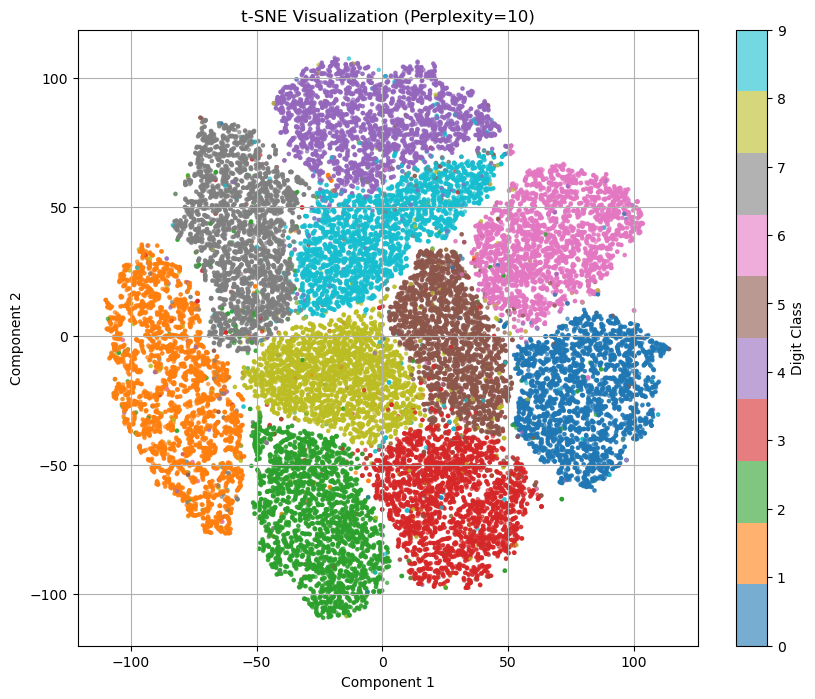


Running t-SNE with perplexity=30...
Completed in 977.76 seconds
KL divergence: 2.5017
Trustworthiness: 0.9911


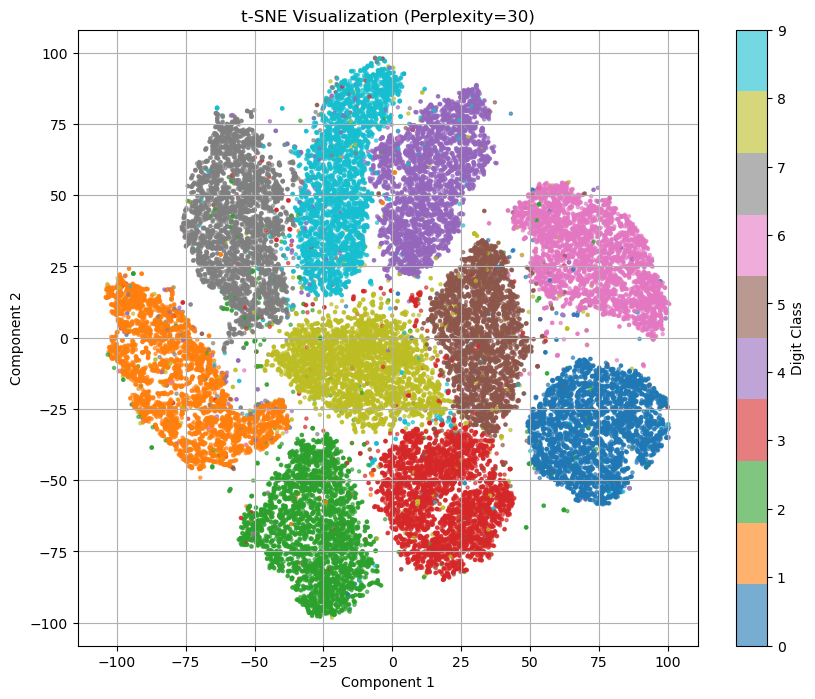


Running t-SNE with perplexity=50...
Completed in 1024.29 seconds
KL divergence: 2.3608
Trustworthiness: 0.9902


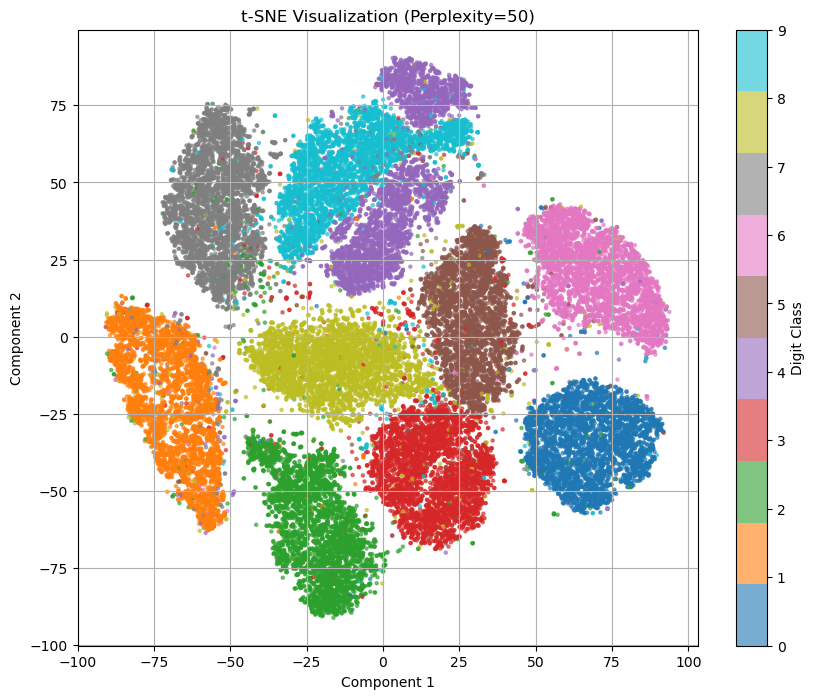


Running t-SNE with perplexity=100...
Completed in 1074.36 seconds
KL divergence: 2.1414
Trustworthiness: 0.9885


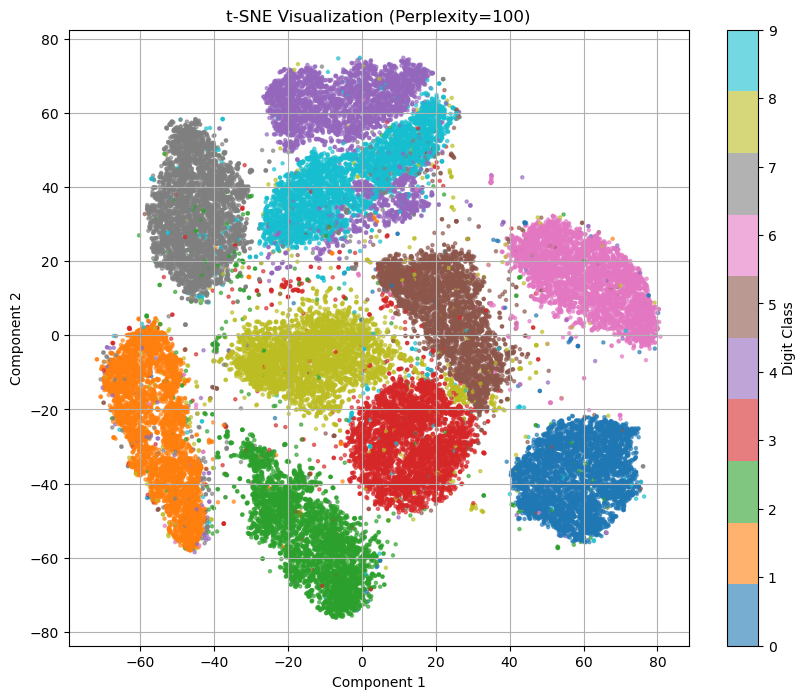

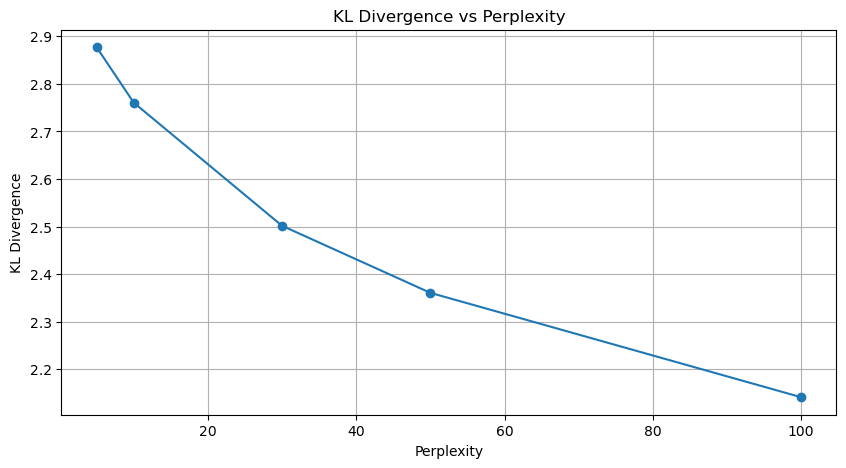

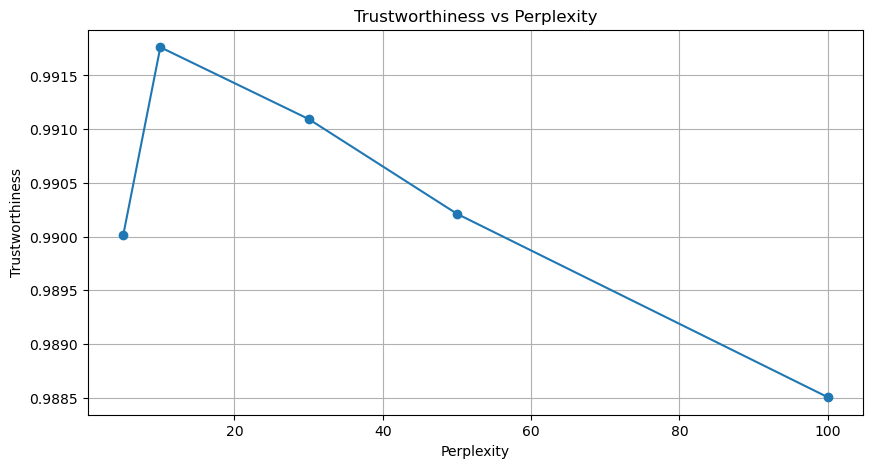


Optimal perplexity based on trustworthiness: 10

Optimal Perplexity  KL Divergence: 100


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import trustworthiness
import time

# Load MNIST dataset
mnist = datasets.fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data
y = mnist.target.astype(int)

# Use a subset of the data for faster computation 
X_subset, _, y_subset, _ = train_test_split(X, y, train_size=40000, random_state=42, stratify=y)

# Function to plot embeddings
def plot_embeddings(X_emb, y, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y, cmap='tab10', alpha=0.6, s=5)
    plt.colorbar(scatter, label='Digit Class')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# 1. PCA Implementation
print("Running PCA...")
start_time = time.time()
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_subset)
print(f"PCA completed in {time.time() - start_time:.2f} seconds")

# Plot PCA results
plot_embeddings(X_pca, y_subset, 'PCA Visualization of MNIST Digits')

# 2. t-SNE Implementation
print("Running t-SNE...")
start_time = time.time()
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_subset)
print(f"t-SNE completed in {time.time() - start_time:.2f} seconds")

# Plot t-SNE results
plot_embeddings(X_tsne, y_subset, 't-SNE Visualization of MNIST Digits (Perplexity=30)')

# 3. Trustworthiness Calculation
def calculate_trustworthiness(X_high, X_low, k=5):
    # Calculate pairwise distances in high and low dimensional spaces
    D_high = pairwise_distances(X_high)
    D_low = pairwise_distances(X_low)
    
    # Find k-nearest neighbors in high and low dimensional spaces
    nbrs_high = NearestNeighbors(n_neighbors=k+1).fit(X_high)
    _, indices_high = nbrs_high.kneighbors(X_high)
    
    nbrs_low = NearestNeighbors(n_neighbors=k+1).fit(X_low)
    _, indices_low = nbrs_low.kneighbors(X_low)
    
    # Remove self from neighbor indices
    indices_high = indices_high[:, 1:]
    indices_low = indices_low[:, 1:]
    
    # Calculate trustworthiness
    n = X_high.shape[0]
    trust = 0.0
    
    for i in range(n):
        # Find neighbors in high-D that are not in low-D's k-nearest neighbors
        U = set(indices_high[i]) - set(indices_low[i])
        
        for j in U:
            # Find rank of j in low-D space
            rank_j_in_low = np.where(indices_low[i] == j)[0]
            if len(rank_j_in_low) > 0:
                r = rank_j_in_low[0] + 1  # +1 because we removed self
                trust += (r - k)
    
    trust = 1 - (2 / (n * k * (2 * n - 3 * k - 1))) * trust
    return trust

# Calculate trustworthiness for PCA and t-SNE
k = 12  # Number of neighbors to consider
#trust_pca = calculate_trustworthiness(X_subset, X_pca, k=k)
#trust_tsne = calculate_trustworthiness(X_subset, X_tsne, k=k)

# Compare with sklearn's implementation
trust_pca_sk = trustworthiness(X_subset, X_pca, n_neighbors=k)
trust_tsne_sk = trustworthiness(X_subset, X_tsne, n_neighbors=k)

#print(f"\nTrustworthiness (PCA, custom): {trust_pca:.4f}")
print(f"Trustworthiness (PCA, sklearn): {trust_pca_sk:.4f}")
#print(f"Trustworthiness (t-SNE, custom): {trust_tsne:.4f}")
print(f"Trustworthiness (t-SNE, sklearn): {trust_tsne_sk:.4f}")

# 4. Compare PCA and t-SNE results
#print("\nComparison of PCA and t-SNE:")
#print(f"- PCA preserves global structure better (Trustworthiness: {trust_pca:.4f})")
#print(f"- t-SNE preserves local structure better (Trustworthiness: {trust_tsne:.4f})")

# 5. Study the effect of perplexity on t-SNE
perplexities = [5, 10, 30, 50, 100]
kl_divergences = []
trust_scores = []

for perplexity in perplexities:
    print(f"\nRunning t-SNE with perplexity={perplexity}...")
    start_time = time.time()
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    X_tsne_temp = tsne.fit_transform(X_subset)
    kl_divergence = tsne.kl_divergence_
    kl_divergences.append(kl_divergence)
    
    # Calculate trustworthiness
    trust = trustworthiness(X_subset, X_tsne_temp, n_neighbors=k)
    trust_scores.append(trust)
    
    print(f"Completed in {time.time() - start_time:.2f} seconds")
    print(f"KL divergence: {kl_divergence:.4f}")
    print(f"Trustworthiness: {trust:.4f}")
    
    # Plot the results
    plot_embeddings(X_tsne_temp, y_subset, f't-SNE Visualization (Perplexity={perplexity})')

# Plot KL divergence vs perplexity
plt.figure(figsize=(10, 5))
plt.plot(perplexities, kl_divergences, marker='o')
plt.title('KL Divergence vs Perplexity')
plt.xlabel('Perplexity')
plt.ylabel('KL Divergence')
plt.grid(True)
plt.show()

# Plot Trustworthiness vs perplexity
plt.figure(figsize=(10, 5))
plt.plot(perplexities, trust_scores, marker='o')
plt.title('Trustworthiness vs Perplexity')
plt.xlabel('Perplexity')
plt.ylabel('Trustworthiness')
plt.grid(True)
plt.show()

# Find optimal perplexity
optimal_idx = np.argmax(trust_scores)
optimal_perplexity = perplexities[optimal_idx]
print(f"\nOptimal perplexity based on trustworthiness: {optimal_perplexity}")

optimal_idx2 = np.argmin(kl_divergences)  
optimal_perplexity2 = perplexities[optimal_idx2]
print(f"\nOptimal Perplexity  KL Divergence: {optimal_perplexity2}")


Running t-SNE with perplexity=130...
Completed in 1221.33 seconds
KL divergence: 2.0585
Trustworthiness: 0.9877


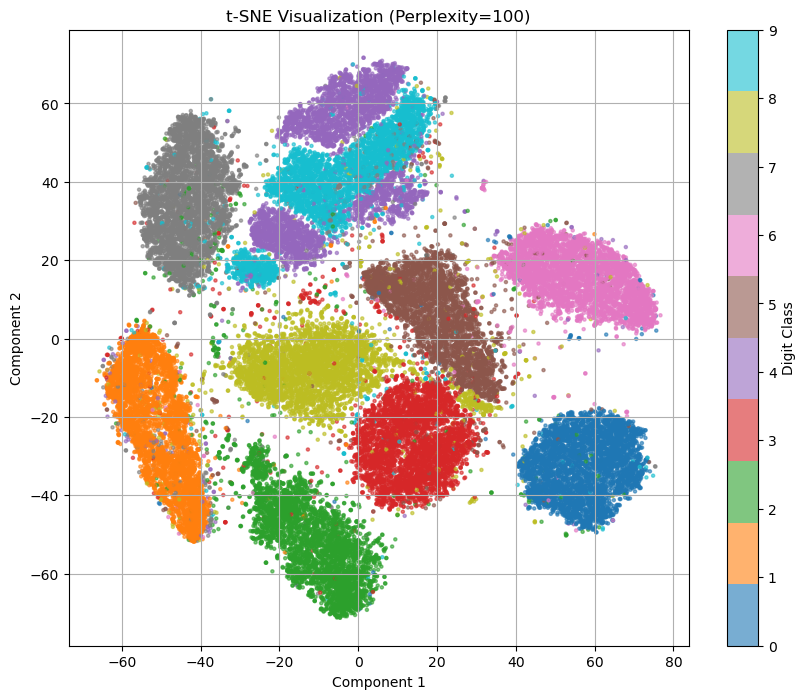

In [11]:
print(f"\nRunning t-SNE with perplexity=130...")
start_time = time.time()
tsne = TSNE(n_components=2, random_state=42, perplexity=130)
X_tsne_temp = tsne.fit_transform(X_subset)
kl_divergence = tsne.kl_divergence_
kl_divergences.append(kl_divergence)
    
# Calculate trustworthiness
trust = trustworthiness(X_subset, X_tsne_temp, n_neighbors=k)
trust_scores.append(trust)
    
print(f"Completed in {time.time() - start_time:.2f} seconds")
print(f"KL divergence: {kl_divergence:.4f}")
print(f"Trustworthiness: {trust:.4f}")
    
# Plot the results
plot_embeddings(X_tsne_temp, y_subset, f't-SNE Visualization (Perplexity={perplexity})')